In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
treino = pd.read_csv("train.csv")
teste = pd.read_csv("test.csv")

treino = treino.drop(columns=['media_receita','media_despesa','nome', 'sequencial_candidato'])

In [51]:
numeric_feats = treino.dtypes[treino.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano')
numeric_feats = numeric_feats.drop('situacao')

treino[numeric_feats] = np.log1p(treino[numeric_feats])

teste[numeric_feats] = np.log1p(teste[numeric_feats])

In [52]:
treino_X = treino.loc[:,:'ocupacao']
treino_Y = treino.loc[:,'situacao']

In [53]:
treino_X = pd.get_dummies(treino_X)

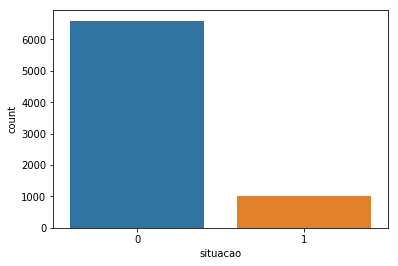

In [54]:
sns.countplot(treino_Y)

É clara a diferença entre a quantidade de instâncias da classe nao_eleito e eleito. Isso pode levar o modelo a aprender de forma errada a classificar os exemplos de teste.

Para balancear as classes usarei a técnica de under-sampling, cluser centroids.

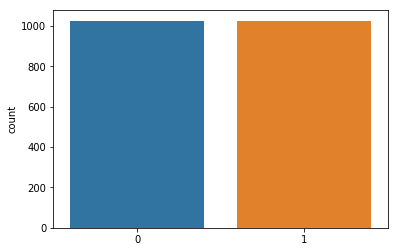

In [55]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
x_cc, y_cc = cc.fit_sample(treino_X, treino_Y)
y_cc = y_cc[:,np.newaxis]

sns.countplot(y_cc[:,0])

Com a mesma quantidade de instâncias entre as duas classes, a chance de o modelo sofrer de unerfiting é bem menor.

A seguir inicio o treinamento de alguns modelos a partir dos dados filtrados.

## Regressão Logística

In [56]:
data = np.concatenate((x_cc, y_cc), axis=1)
data = np.random.permutation(data)
x_cc = data[:,0:-1]
y_cc = data[:,-1]

In [57]:
from sklearn.model_selection import KFold
from sklearn import metrics

def cv_report(model, predictors, outcome, nfolds):
    
    kf = KFold(n_splits=nfolds)
    f1_score = []
    for train, validation in kf.split(predictors):
        train_predictors = (predictors[train,:])
        train_target =  outcome[train]
        model.fit(train_predictors, train_target)
        
        y = model.predict(predictors[validation,:])
        report = metrics.classification_report(outcome[validation], y, output_dict=True)
        f1_score.append(report['1.0']['f1-score'])
        
    return np.mean(f1_score)

In [61]:
from sklearn.linear_model import LogisticRegression

lambdas = np.arange(0.01,2,0.01).tolist()

cv_logRegression = [cv_report(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1), x_cc, y_cc, 5).mean()
            for lbd in lambdas]
cv_logRegression = pd.Series(cv_logRegression, index = lambdas)

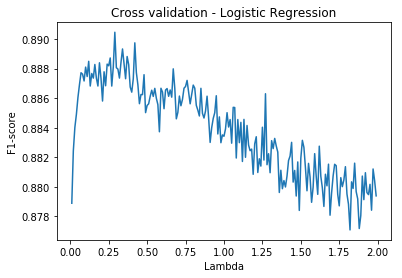

O melhor alpha é 0.29000000000000004, com F1 = 0.8904568193197149


In [62]:
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()

print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))